<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Взвешивание-классов" data-toc-modified-id="Взвешивание-классов-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Взвешивание классов</a></span></li><li><span><a href="#Upsampling" data-toc-modified-id="Upsampling-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Upsampling</a></span></li><li><span><a href="#Downsample" data-toc-modified-id="Downsample-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Downsample</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from random import randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
from sklearn import tree

df = pd.read_csv('/datasets/Churn.csv')
pd.set_option('display.max_columns', None) # отобразим все столбцы в датасете
display(df.head()) # для начала посмотрим на первые 5 строк таблицы с данными
df.info() # также выведем общую информацию о таблице

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Данные состоят из таблицы с 14 столбцами. В столбцах использованы типы данных `float64`, `int64` и `object`. 

Описание столбцов:
    
* RowNumber — индекс строки в данных,
* CustomerId — уникальный идентификатор клиента,
* Surname — фамилия,
* CreditScore — кредитный рейтинг,
* Geography — страна проживания,
* Gender — пол,
* Age — возраст,
* Tenure — сколько лет человек является клиентом банка,
* Balance — баланс на счёте,
* NumOfProducts — количество продуктов банка, используемых клиентом,
* HasCrCard — наличие кредитной карты,
* IsActiveMember — активность клиента,
* EstimatedSalary — предполагаемая зарплата,
* Exited — факт ухода клиента (целевой признак). 


Тип данных столбца Tenure нужно изменить на целочисленный, так как в нём заполнены только целые значения количества лет, которые человек является клиентом банка. В столбце Tenure также есть пропуски данных.

In [2]:
df['Tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

Природа пропусков столбца Tenure неизвестна и я решила их заполнить рандомными числами в диапазоне от 0 до 10, исходя из описательных статистик столбца Tenure, чтобы не влиять на распределение. 

In [3]:
df['Tenure'] = df['Tenure'].fillna(randint(0,10))

Изменим тип данных в столбце Tenure с вещественного на целочисленный, так как в этом столбце хранится полное количество лет, измеряемое целыми положительными числами.

In [4]:
df['Tenure'].describe()

count    10000.000000
mean         5.179700
std          2.819398
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: Tenure, dtype: float64

In [5]:
df['Tenure'] = df['Tenure'].astype('int64')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Удалим столбцы RowNumber, CustomerId, Surname, которые могут снизить качество модели при её обучении. От этих столбцов предсказания оттока клиентов не зависит.

In [7]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

Преобразуем категориальные признаки в численные с помощью техники прямого кодирования (One-Hot Encoding). 

In [8]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Разобьём датасет на три выборки: обучающую, валидационную и тестовую, как правило, можно использовать разделение 3:1:1.

In [9]:
# 1. отделим 20% данных для тестовой выборки
df_valid_train, df_test = train_test_split(df_ohe, test_size=0.20, random_state=12345) 

# проверим, что в тестовой выборке 20% данных
df_test.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 7867 to 694
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        2000 non-null   int64  
 1   Age                2000 non-null   int64  
 2   Tenure             2000 non-null   int64  
 3   Balance            2000 non-null   float64
 4   NumOfProducts      2000 non-null   int64  
 5   HasCrCard          2000 non-null   int64  
 6   IsActiveMember     2000 non-null   int64  
 7   EstimatedSalary    2000 non-null   float64
 8   Exited             2000 non-null   int64  
 9   Geography_Germany  2000 non-null   uint8  
 10  Geography_Spain    2000 non-null   uint8  
 11  Gender_Male        2000 non-null   uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 162.1 KB


In [10]:
# 2. отделим 20% данных для валидационной выборки, 
# т.к. мы уже отделили часть, то от оставшейся части данных нужно взять 25%, 
# чтобы получить валидационную выборку, равную тестовой по размеру
df_train, df_valid = train_test_split(df_valid_train, test_size=0.25, random_state=12345) 

# проверим, что в вылидационной выборке 20% данных
df_valid.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 2358 to 4995
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        2000 non-null   int64  
 1   Age                2000 non-null   int64  
 2   Tenure             2000 non-null   int64  
 3   Balance            2000 non-null   float64
 4   NumOfProducts      2000 non-null   int64  
 5   HasCrCard          2000 non-null   int64  
 6   IsActiveMember     2000 non-null   int64  
 7   EstimatedSalary    2000 non-null   float64
 8   Exited             2000 non-null   int64  
 9   Geography_Germany  2000 non-null   uint8  
 10  Geography_Spain    2000 non-null   uint8  
 11  Gender_Male        2000 non-null   uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 162.1 KB


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 492 to 3295
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        6000 non-null   int64  
 1   Age                6000 non-null   int64  
 2   Tenure             6000 non-null   int64  
 3   Balance            6000 non-null   float64
 4   NumOfProducts      6000 non-null   int64  
 5   HasCrCard          6000 non-null   int64  
 6   IsActiveMember     6000 non-null   int64  
 7   EstimatedSalary    6000 non-null   float64
 8   Exited             6000 non-null   int64  
 9   Geography_Germany  6000 non-null   uint8  
 10  Geography_Spain    6000 non-null   uint8  
 11  Gender_Male        6000 non-null   uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 486.3 KB


In [12]:
# для каждой выборки разделим данные на признаки и целевой признак

features_train = df_train.drop(['Exited'], axis=1)
target_train = df_train['Exited']

features_test = df_test.drop(['Exited'], axis=1)
target_test = df_test['Exited'] 

features_valid = df_valid.drop(['Exited'], axis=1)
target_valid = df_valid['Exited']

Отмасштабируем численные признаки с помощью метода стандартизации данных.

In [13]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 
           'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [14]:
features_train.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
492,-0.134048,-0.078068,-0.428516,0.076163,0.816929,0,1,0.331571,0,0,0
6655,-1.010798,0.494555,0.633482,0.136391,-0.896909,1,1,-0.727858,0,0,1


In [15]:
features_valid.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2358,0.175393,0.399118,-1.490514,1.385698,-0.896909,0,1,-1.466761,0,0,1
8463,-1.299609,0.971741,-1.136515,-1.232442,-0.896909,1,0,0.254415,0,1,1


In [16]:
features_test.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7867,-0.123733,0.685430,-0.782516,-1.232442,-0.896909,1,1,0.980212,0,1,0
1402,1.083087,-0.937002,0.987481,0.858518,-0.896909,1,0,-0.390486,0,0,1


Исходный набор данных разбит на обучающую, валидационную и тестовую выборки. Выделены признаки (features), по которым будет предсказан целевой признак (target). Численные признаки отмасштабированы, для категориальных признаков использована техника прямого кодирования.

## Исследование задачи

Исследование оттока клиентов - это задача бинарной классификации. 
Исследуем качество разных моделей на примере изученных в спринте: 
* дерево решений,
* случайный лес,
* логистическая регрессии.

In [17]:
#сначала посмотрим модель дерева решений
for depth in range(1,15,1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    print('max_depth:',depth,'F1:',f1_score(target_valid, predictions_valid))

max_depth: 1 F1: 0.0
max_depth: 2 F1: 0.5037037037037037
max_depth: 3 F1: 0.39382239382239387
max_depth: 4 F1: 0.430188679245283
max_depth: 5 F1: 0.5488372093023256
max_depth: 6 F1: 0.5113043478260869
max_depth: 7 F1: 0.5557299843014128
max_depth: 8 F1: 0.5398773006134968
max_depth: 9 F1: 0.5337331334332833
max_depth: 10 F1: 0.5348837209302326
max_depth: 11 F1: 0.5214899713467048
max_depth: 12 F1: 0.5113636363636364
max_depth: 13 F1: 0.5101214574898785
max_depth: 14 F1: 0.5013550135501355


Лучшее значение модели дерева решений достигается на max_depth=7, при котором F1=0,5556

In [18]:
#лучшую модель сохраним в переменной
model_tree = DecisionTreeClassifier(max_depth=7, random_state=12345)
model_tree.fit(features_train, target_train)

tree_predicted_valid = model_tree.predict(features_valid)

In [19]:
#далее исследуем модель случайный лес 
best_depth = 0
best_estimators = 0
best_result = 0    
for depth in range(1, 20, 1):
    for estimators in range(1, 80, 2):
        model=RandomForestClassifier(max_depth=depth, 
                                     n_estimators=estimators,
                                     random_state=1234)
        
        model.fit(features_train, target_train)
        predictions_valid=model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)

        if best_result < result:
            best_result = result
            best_estimators = estimators
            best_depth = depth
            
            
print('max_depth:', best_depth, 
      'n_estimators:', best_estimators,
      'F1:', best_result) 

max_depth: 19 n_estimators: 7 F1: 0.5832106038291606


Лучшее значение модели случайный лес достигается на max_depth=19,n_estimators: 7, при котором F1=0,5831

In [20]:
# лучшую модель сохраним в переменной
model_forest = RandomForestClassifier(max_depth=19, random_state=12345, n_estimators=7) 
model_forest.fit(features_train, target_train)
forest_predicted_valid = model_forest.predict(features_valid)

In [21]:
# наконец рассмотрим работу модели логистической регрессии

model_regression = LogisticRegression(random_state=12345)
model_regression.fit(features_train, target_train)
regression_predicted_valid = model_regression.predict(features_valid)
print('F1:',f1_score(target_valid,regression_predicted_valid))

F1: 0.30451127819548873


У модели логической регрессии получилась самая низкая точность.

Чтобы оценить адекватность модели, проверим, как часто в целевом признаке встречается класс «1» или «0».

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<AxesSubplot:>

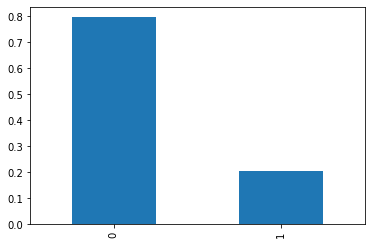

In [22]:
class_frequency = df_ohe['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Из диаграммы видно, что классы не сбалансированы. 

Построим матрицу ошибок для каждой модели:

In [23]:
model_tree = confusion_matrix(target_valid, tree_predicted_valid)
model_tree

array([[1540,   69],
       [ 214,  177]])

In [24]:
model_forest = confusion_matrix(target_valid, forest_predicted_valid)
model_forest

array([[1503,  106],
       [ 204,  187]])

In [25]:
model_regression = confusion_matrix(target_valid, regression_predicted_valid)
model_regression

array([[1549,   60],
       [ 310,   81]])

В матрице на диагонали расположены верные предсказания моделей, вне диагонали - ошибочные. Для исследования оттока клиентов важными ошибками являются False Negative ответы. Модель предсказала, что клиенты не уйдут, а они ушли и компания неожиданно потеряла деньги. Меньше всего False Negative ответов у модели случайного леса (их всего 204).

Посчитаем полноту для каждой модели. Она определяет, какую долю положительных среди всех ответов выделила модель.

In [26]:
print('Полнота Логистической регресии:{:.2f}'.format(recall_score(target_valid, regression_predicted_valid)))
print('Полнота Решающего дерева:{:.2f}'.format(recall_score(target_valid, tree_predicted_valid)))
print('Полнота Случайного леса:{:.2f}'.format(recall_score(target_valid, forest_predicted_valid)))

Полнота Логистической регресии:0.21
Полнота Решающего дерева:0.45
Полнота Случайного леса:0.48


Посчитаем точность для каждой модели. Она определяет, как много отрицательных ответов нашла модель, пока искала положительные.

In [27]:
print('Точность Логистической регресии:{:.2f}'.format(precision_score(target_valid, regression_predicted_valid)))
print('Точность Решающего дерева:{:.2f}'.format(precision_score(target_valid, tree_predicted_valid)))
print('Точность Случайного леса:{:.2f}'.format(precision_score(target_valid, forest_predicted_valid)))

Точность Логистической регресии:0.57
Точность Решающего дерева:0.72
Точность Случайного леса:0.64


В данных прослеживается дисбаланс классов. Проверку на адекватность рассмотренные модели не проходят. 

В исследовании качества моделей важны метрики и полноты, и точности. Рассмотрена F1-мера, которая позволяет одновременно следить за полнотой и точностью. В идеале F1-мера должна стремиться к 1, это означает, что полнота и точность стремятся к 1. Но из-за дисбаланса классов F1-мера наших моделей от единицы очень далека. 

## Борьба с дисбалансом

### Взвешивание классов

Придадим объектам редкого класса 1 больший вес используя гиперпараметр class_weight='balanced'

In [28]:
#дерево решений
for depth in range(1,20,1):
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=12345,class_weight='balanced' )
    model_tree.fit(features_train, target_train)
    tree_predicted_valid = model_tree.predict(features_valid)
    print('max_depth:',depth,'F1:',f1_score(target_valid, tree_predicted_valid))

max_depth: 1 F1: 0.4750733137829912
max_depth: 2 F1: 0.49761677788369874
max_depth: 3 F1: 0.49761677788369874
max_depth: 4 F1: 0.5170454545454546
max_depth: 5 F1: 0.5489078822412156
max_depth: 6 F1: 0.5587044534412956
max_depth: 7 F1: 0.5535353535353534
max_depth: 8 F1: 0.5454545454545454
max_depth: 9 F1: 0.5132223310479921
max_depth: 10 F1: 0.48942598187311176
max_depth: 11 F1: 0.48151848151848153
max_depth: 12 F1: 0.48625792811839325
max_depth: 13 F1: 0.4749455337690632
max_depth: 14 F1: 0.4983089064261555
max_depth: 15 F1: 0.49449204406364755
max_depth: 16 F1: 0.48588957055214727
max_depth: 17 F1: 0.48258706467661694
max_depth: 18 F1: 0.48402948402948404
max_depth: 19 F1: 0.4949238578680203


Лучший результ с глубиной 6 F1=0.5586, практически не отличается от результата с несбалансированнными данными

In [29]:
#случайный лес
best_depth = 0
best_estimators = 0
best_result = 0    
for depth in range(1, 30, 1):
    for estimators in range(50, 150, 2):
        model_forest=RandomForestClassifier(max_depth=depth, 
                                     n_estimators=estimators,
                                     random_state=1234,
                                    class_weight='balanced')
        
        model_forest.fit(features_train, target_train)
        forest_predicted_valid=model_forest.predict(features_valid)
        result = f1_score(target_valid, forest_predicted_valid)

        if best_result < result:
            best_result = result
            best_estimators = estimators
            best_depth = depth
            
            
print('max_depth:', best_depth, 
      'n_estimators:', best_estimators,
      'F1:', best_result) 

max_depth: 11 n_estimators: 100 F1: 0.6053333333333333


Лучший результат max_depth =11, n_estimators=100, при котором F1 = 0.6052. Порог 0.59 достигнут

In [30]:
# лучшую модель сохраним в переменной
model_forest_best = RandomForestClassifier(max_depth=11, random_state=12345, n_estimators=100) 
model_forest_best.fit(features_train, target_train)
forest_predicted_valid = model_forest_best.predict(features_valid)

In [31]:
#логистическая регрессия

model_regression = LogisticRegression(random_state=12345,class_weight='balanced' )
model_regression.fit(features_train, target_train)
regression_predicted_valid = model_regression.predict(features_valid)
print('F1:',f1_score(target_valid,regression_predicted_valid))

F1: 0.47424511545293074


У модели логической регрессии опять получилась самая низкая точность, но уже выше по сравнению с несбалансированными данными.

### Upsampling

Попробуем способ борьбы с дисбалансом классов - upsampling, или увеличение выборки. Выборка будет увеличена за счет повторения объектов более редкого класса в ней. Для начала разделим обучающую выборку на отрицательные и положительные объекты:

In [32]:
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(4781, 11)
(1219, 11)
(4781,)
(1219,)


Затем скопируем несколько раз положительные объекты.

С учётом полученных данных создадим новую обучающую выборку.

Перемешаем данные с помощью функции shuffle().

Чтобы объединить все действия возпользуемся функцией upsample c тремя параметрами: features — признаки, target — целевой признак, repeat — количество повторений. Функция вернёт признаки и целевой признак после операции upsampling.

In [33]:
def upsample(features, target, repeat):

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    repeat = 4
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9657, 11)
(9657,)


Обучение с помощью модели Дерево решения

In [34]:
%%time

for depth in range(1,75,1):
    model_tree=DecisionTreeClassifier(max_depth=depth,random_state=1234)
    model_tree.fit(features_upsampled,target_upsampled)
    tree_predicted_valid = model_tree.predict(features_valid)
    print('max_depth:',depth,'F1:',f1_score(target_valid,tree_predicted_valid))

max_depth: 1 F1: 0.4750733137829912
max_depth: 2 F1: 0.49761677788369874
max_depth: 3 F1: 0.49761677788369874
max_depth: 4 F1: 0.5170454545454546
max_depth: 5 F1: 0.5489078822412156
max_depth: 6 F1: 0.5587044534412956
max_depth: 7 F1: 0.5549949545913219
max_depth: 8 F1: 0.5553191489361702
max_depth: 9 F1: 0.5122669283611384
max_depth: 10 F1: 0.4796828543111993
max_depth: 11 F1: 0.48643006263048016
max_depth: 12 F1: 0.4805194805194805
max_depth: 13 F1: 0.4809575625680087
max_depth: 14 F1: 0.4782122905027933
max_depth: 15 F1: 0.4784688995215311
max_depth: 16 F1: 0.4723247232472324
max_depth: 17 F1: 0.4801980198019802
max_depth: 18 F1: 0.48129675810473815
max_depth: 19 F1: 0.47148288973384034
max_depth: 20 F1: 0.47887323943661975
max_depth: 21 F1: 0.47887323943661975
max_depth: 22 F1: 0.4776500638569604
max_depth: 23 F1: 0.48124191461837007
max_depth: 24 F1: 0.48124191461837007
max_depth: 25 F1: 0.48124191461837007
max_depth: 26 F1: 0.48124191461837007
max_depth: 27 F1: 0.4812419146183700

Лучшее значение модели дерева решений достигается на max_depth=6, при котором F1=0,5586

Результаты стали лучше, но требуемого порога в 0.59 мы не достигли.

Обучение с помощью модели Случайный лес

In [35]:
%%time
    
best_depth = 0
best_estimators = 0
best_result = 0    
for depth in range(1, 20, 1):
    for estimators in range(50, 150, 2):
        model_forest=RandomForestClassifier(max_depth=depth, 
                                     n_estimators=estimators,
                                     random_state=1234)
        model_forest.fit(features_upsampled,target_upsampled)
        forest_predicted_valid=model_forest.predict(features_valid)
        result = f1_score(target_valid, forest_predicted_valid)

        if best_result < result:
            best_result = result
            best_estimators = estimators
            best_depth = depth
            
            
print('max_depth:', best_depth, 
      'n_estimators:', best_estimators,
      'F1:', best_result) 

max_depth: 11 n_estimators: 52 F1: 0.6011695906432749
CPU times: user 10min 38s, sys: 1.99 s, total: 10min 40s
Wall time: 10min 41s


Лучшее значение max_depth=11,n_estimators = 52, при котором F1=0.6012. Достигли метрики 0.59

In [36]:
# лучшую модель сохраним в переменной
model_forest_best1 = RandomForestClassifier(max_depth=11, random_state=12345, n_estimators=52) 
model_forest_best1.fit(features_train, target_train)
forest_predicted_valid = model_forest_best1.predict(features_valid)

Обучение с помощью модели Логистической регрессии

In [37]:
%%time

model_regression=LogisticRegression(solver='liblinear')
model_regression.fit(features_upsampled,target_upsampled)
regression_predicted_valid = model_regression.predict(features_valid)
print('F1:',f1_score(target_valid,regression_predicted_valid))


F1: 0.47543859649122816
CPU times: user 21.4 ms, sys: 51.8 ms, total: 73.2 ms
Wall time: 32.7 ms


Мера F1 поменялась. Стала гораздо лучше. F1=0.4753

### Downsample

Ещё один способ борьбы с дисбалансом - это уменьшение выборки, или downsampling. Попробуем и этот способ:

In [38]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=0.25, random_state=12345)] +
                                     [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=0.25, random_state=12345)] +
                                     [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled,
                                                      random_state=12345)
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

После балансирования данных. Обучение с помощью модели Дерево решения

In [39]:
%%time

for depth in range(1,75,1):
    model_tree=DecisionTreeClassifier(max_depth=depth,random_state=1234)
    model_tree.fit(features_downsampled, target_downsampled)
    tree_predicted_valid = model_tree.predict(features_valid)
    print('max_depth:',depth,'F1:',f1_score(target_valid,tree_predicted_valid))

max_depth: 1 F1: 0.4750733137829912
max_depth: 2 F1: 0.49761677788369874
max_depth: 3 F1: 0.5118376550169109
max_depth: 4 F1: 0.49569377990430613
max_depth: 5 F1: 0.5278491859468724
max_depth: 6 F1: 0.5434380776340111
max_depth: 7 F1: 0.5441039925719591
max_depth: 8 F1: 0.5114503816793894
max_depth: 9 F1: 0.510677808727948
max_depth: 10 F1: 0.5027932960893855
max_depth: 11 F1: 0.4821092278719398
max_depth: 12 F1: 0.4869251577998196
max_depth: 13 F1: 0.4745454545454546
max_depth: 14 F1: 0.4675324675324675
max_depth: 15 F1: 0.46771378708551486
max_depth: 16 F1: 0.4637931034482759
max_depth: 17 F1: 0.4691358024691359
max_depth: 18 F1: 0.46986899563318774
max_depth: 19 F1: 0.46113989637305697
max_depth: 20 F1: 0.4670763827919227
max_depth: 21 F1: 0.4670763827919227
max_depth: 22 F1: 0.4670763827919227
max_depth: 23 F1: 0.4670763827919227
max_depth: 24 F1: 0.4670763827919227
max_depth: 25 F1: 0.4670763827919227
max_depth: 26 F1: 0.4670763827919227
max_depth: 27 F1: 0.4670763827919227
max_de

Лучшее значение при max_depth = 7 F1= 0.5440

Результаты немного хуже, чем при увеличении выборки.Требуемого порога в 0.59 мы не достигли

Обучение с помощью модели Случайный лес

In [40]:
%%time
    
best_depth = 0
best_estimators = 0
best_result = 0    
for depth in range(1, 20, 1):
    for estimators in range(50, 150, 2):
        model_forest=RandomForestClassifier(max_depth=depth, 
                                     n_estimators=estimators,
                                     random_state=1234)
        model_forest.fit(features_downsampled, target_downsampled)
        forest_predicted_valid=model_forest.predict(features_valid)
        result = f1_score(target_valid, forest_predicted_valid)

        if best_result < result:
            best_result = result
            best_estimators = estimators
            best_depth = depth
            
            
print('max_depth:', best_depth, 
      'n_estimators:', best_estimators,
      'F1:', best_result) 

max_depth: 8 n_estimators: 100 F1: 0.5799404170804369
CPU times: user 4min 39s, sys: 1.18 s, total: 4min 40s
Wall time: 4min 41s


Лучшее значение max_depth=8,n_estimators= 100, при котором F1=0.5799. Не достигли метрики 0.59

Обучение с помощью модели Логистической регрессии

In [41]:
%%time

model_regression=LogisticRegression(solver='liblinear')
model_regression.fit(features_downsampled, target_downsampled)
regression_predicted_valid = model_regression.predict(features_valid)
print('F1:',f1_score(target_valid,regression_predicted_valid))


F1: 0.4723441615452151
CPU times: user 13.6 ms, sys: 15.9 ms, total: 29.6 ms
Wall time: 11.2 ms


При борьбе с дисбалансом с помощью уменьшения выборки мы не достигли меры f1 0.59. Лидирующие позиции имеет модель случайного леса при борьбе с дисбалансом при взвешивании классов.

Обратимся ещё к одной метрике качества модели, построим ROC-кривую, или кривую ошибок для лучших моделей. Для модели, которая всегда отвечает случайно, ROC-кривая выглядит как прямая, идущая из левого нижнего угла в верхний правый. Чем график выше, тем больше значение истинно положительных ответов (TPR) и лучше качество модели.

In [42]:
def auc_roc(model, name):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} ROC-кривая'.format(name))
    plt.show()
    
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('AUC-ROC равно:', auc_roc)
    return 

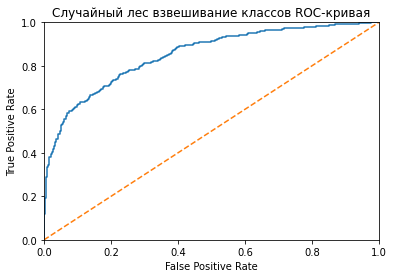

AUC-ROC равно: 0.8507690913801681


In [43]:
auc_roc(model_forest_best, 'Случайный лес взвешивание классов')

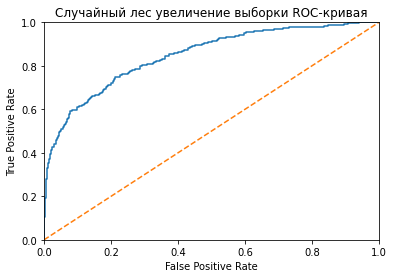

AUC-ROC равно: 0.847348434874801


In [44]:
auc_roc(model_forest_best1, 'Случайный лес увеличение выборки')

Получилось, что у Случайного леса немного лучшее значение при взвешивании классов. Метрика AUC-ROC ещё далека от единицы, но и от случайной модели она уже далека.

В итоге способ борьбы с дисбалансом взвешивание классов оказался эффективнее способов downsampling, upsampling. Лучшие результаты F1-меры показывает модель Случайный лес.

## Тестирование модели

In [45]:
#объединим выборки
features_full_train = pd.concat([features_train, features_valid])
target_full_train = pd.concat([target_train, target_valid])

Лучший результат показала модель Random Forest Classifier при взвешивании классов

In [48]:
model_forest_test = RandomForestClassifier(max_depth=11,
                                           n_estimators=100,
                                           random_state=1234,
                                           class_weight='balanced')

model_forest_test.fit(features_full_train, target_full_train)
test_predictions = model_forest_test.predict(features_test)
print('test:', f1_score(target_test, test_predictions))

test: 0.6280193236714976


Посчитаем AUC-ROC для нашей модели и посмотрим насколько она лучше случайной модели

In [50]:
probabilities_test = model_forest_test.predict_proba(features_test)
probabilities_one_test  = probabilities_test [:, 1]

roc_auc_score(target_test, probabilities_one_test)

0.8622227251139323

На объединенной выборке удалось достичь значения 0.8621 F1-меры нашей лучшей модели Случайного леса.

* Модель Случайный лес показала самые лучшие результаты в сравнении с Деревом решений и Логической регрессией.
* Устранив дисбаланс в данных и подобрав гиперпараметры модели удалось достичь F1-меру> 0.59.
* Обученную модель можно использовать для прогнозирования, уйдёт клиент из банка в ближайшее время или нет.